# Categorising data: implementation of a k-nearest-neighbours algotrithm to the MNIST dataset

In this project we write an elementary machine learning algorithm for regonising hand-written numerals from the MNIST dataset. The algorithm we implement is based an example of a k-nearest-neighbours algorithm, which is one of the most basic examples of unsupervised machine learning used in classification problems. The goal of this project is to write an k-nearest-neighbours algorithm for classifying images from the MNIST dataset and finally measure the accuracy of this implementation. The contruction of our k-nearest-neighbours classifier follows the outline given in \[2\].

### Import the required packages

In [ ]:
import numpy as np
import struct as st
from collections import Counter
import time
import matplotlib.pyplot as plt

## The MNIST dataset
The MNIST dataset comprises of 70000 examples (each example begin an image of a handwritten numeral along with a label), which is divided into a training dataset of 60000 examples and a testing set of 10000 examples. The images and labels from the MNIST dataset are available as IDX files here [MNIST dataset](http://yann.lecun.com/exdb/mnist/). In order to use this data for our purposes we convert each dataset into a list of two elements lists (of the form \[image,label\]). The images are then stored as 28$\times$28 ndarrays with each element begin an integer between 0 and 255, denoting the darkness of a particular pixel of the image (there are 28$\times$28 pixels per image), with 0 and 255 being white and black respectively. The labels are simply stored as integer between 0 and 9. This conversion is done using function mnist_idx_unpack defined below.

In [138]:
### REFERENCE 1
def mnist_idx_unpack(images_file,labels_file):
    '''
    Unpacks the MNIST image and label datasets from idx format and combines each image-label pair into a
    two element list containing the corresponding numpy array and integer. Returns the full list of two 
    element lists.

            Parameters:
                    images_file (idx file): collection of handwritten numerals
                    labels_file (idx file): corresponding labels to identify numerals

            Returns:
                    image_dataset (list): 
                        list of image-label pairs, with elements are of the form [image,label] 
                        where each image is a 28 * 28 numpy array of integers between 0 and 255 
                        and each label is an integer between 0 and 9.
    '''
   
    file = {'images' : images_file ,'labels' : labels_file}
    imagesfile = open(file['images'],'rb')

    imagesfile.seek(0)

    # Only read the first 4 bytes which specifies the dimnesionality of the data
    # Here this is 60000 * 28 * 28 for trainig set (or 10000 * 28 * 28 for testing set)
    magic = st.unpack('>4B', imagesfile.read(4))
        
    nImg = st.unpack('>I',imagesfile.read(4))[0] # num of images
    nC = st.unpack('>I',imagesfile.read(4))[0] # num of column (num of pixels in the horizontal direction is 28)
    nR = st.unpack('>I',imagesfile.read(4))[0] # num of rows (num of pixels in the verticle direction is 28)
    
    
    nBytesTotal_images = nImg*nR*nC*1 # since each pixel data is 1 byte
    images_array = 255 - np.asarray(st.unpack('<'+'B'*nBytesTotal_images,imagesfile.read(nBytesTotal_images))).reshape((nImg,nR,nC))
    
    # Do the same for the labels
    labelsfile = open(file['labels'],'rb')
    
    labelsfile.seek(0)
    
    # Only read the first 4 bytes which specifies the dimnesionality of the data
    # Here this is 60000 for trainig labels (or 10000 for testing labels)
    magic = st.unpack('>4B',labelsfile.read(4))
    nLab = st.unpack('>I',labelsfile.read(4))[0] #num of labels
    if nLab != nImg:
        raise ValueError('Number of images must be equal to number of labels')
    
    nBytesTotal_labels = nLab*1 # since each label is 1 byte
    labels_array = np.asarray(st.unpack('>'+'B'*nBytesTotal_labels,labelsfile.read(nBytesTotal_labels))).reshape(nLab)
    
    images_and_labels = []
    for i in range(nLab):
        images_and_labels.append([images_array[i,::-1,::1],labels_array[i]])
        
    return images_and_labels
### END REFERENCE 1

In order to run the next cell you should download and save the training and test dataset files directly from http://yann.lecun.com/exdb/mnist/.

In [139]:
# Unpack the MNIST image and label datasets from idx format and define lists of image-label pairs 
# for both train and test data
train_data = mnist_idx_unpack('train-images.idx3-ubyte','train-labels.idx1-ubyte')
test_data = mnist_idx_unpack('t10k-images.idx3-ubyte','t10k-labels.idx1-ubyte')

## The k-nearest-neighbours algorithm
The k-nearest-neighbours algorithm calculates for a given test image the k nearest images from the training dataset with respect to some chosen metric. From the k nearest images a nearest neighbour is chosen using some means of majority voting. The label from this nearest image in the training set is then assigned as the label for the test image and we generate in this way a dataset comprises of test images along with their learnt labels.

### Choosing the metric
Below we define a function lp_dist which determines the "distance" between two numpy.ndarrays of the same dimensions using a componentwise $\ell_p$ metric. We will use lp_dist to calculate nearest neighbours among train images for a given test image.

In [140]:
def lp_dist(A, B, p_value = 2):
    '''
    Calculates an element-wise little l_p distance between two arrays of the same dimensions.

            Parameters:
                    A (numpy.ndarray): A numpy array of real numbers
                    B (numpy.ndarray): Another numpy array of real numbers
                    p_value (float, optional): value of p in the little l_p distance (default is 2)

            Returns:
                    lp_dist (float): 
                        element-wise little l_p distance between A and B to the power of p
                        
    '''
   
    
    # Check that both A and B are numpy arrays of the same dimensions
    if not ((type(A) is np.ndarray) and (type(B) is np.ndarray)):
        raise TypeError("First two inputs must both be numpy arrays!")
    elif np.shape(A) != np.shape(B):
        raise TypeError("The dimensions of the two arrays must be equal!")
        
    
    else:
        # Create new array containing elementwise differences (with signs) between A and B 
        C = A - B
        
        # Initiate the l_p distance at zero
        lp_dist = 0
        
        # Sum the absolute value to the power p of each element in C
        for d in np.nditer(C):
                lp_dist += np.abs(d)**p_value
    return lp_dist

### Finding the nearest neighbour
In order to find a best appoximate label for an image from the test dataset, we choose a "best" candidate from a list of k nearest neighbours in the train dataset calculated using the metric given by lp_dist. To determine a best candidate from this list of k neighbouring images, we implement a majority voting system where each train image from the k nearest if given a vote inversely proportional towards distance from the test image.

In [141]:
def nearest_label_finder(test_image, train_image_dataset, k = 10 ,p = 2):
    
    '''
    Calculates nearest neighbours of the test_image among images in the train_image_dataset with 
    respect to the distance function lp_dist with p_value equal to p.

            Parameters:
                    
                    test_image (numpy.ndarray): 28 * 28 numpy array of integers between 0 and 255
                    
                    train_image_dataset (list): 
                        list of image-label pairs of the form [image,label] where each image is a 
                        28 * 28 numpy array of integers between 0 and 255 and each label is an integer 
                        between 0 and 9.
                        
                    k (int, optional): Number of nearest neighbours we want to find (default is 10).
                    
                    p (float, optional): value of p in the little l_p distance (default is 2)
                    
                    

            Returns: 
                
                    nearest_label (int): integer between 0 and 9 denoting the label of the nearest image.
                        
    '''
    
    # Initiate an empty list which will contain all train images along with their distances to test_image
    # Elements in train_image_distances will be of the form [[image,label],distance_to_test_image]
    train_image_distances = []
    
    # Fill the list train_image_distances
    for train_image_pair in train_image_dataset:
        train_image_distances.append([train_image_pair,lp_dist(test_image,train_image_pair[0],p)])
    
    
    # Take the nearest k train_images and put them along with their distances to test_image in a new list
    train_image_distances = sorted(train_image_distances, key = lambda pair: pair[1])
    knearest = train_image_distances[:k].copy()
    
    
    # initiate dictionary with votes for each label at zero
    # items in the dictionary will be of the form (label,number of votes)
    votes = Counter()   
    
    # the voting system will be inversely biased towards distance from the test image
    for image_item in knearest:
        if image_item[1] == 0:
            nearest_label = image_item[0][1]
            return nearest_label
        else:
            votes[image_item[0][1]] += 1/image_item[1]
            
    # order the dictionary according to votes
    sorted_votes = sorted(list(votes.items()), reverse=True, key = lambda x : x[1])
    
    
    # check to see whether there are more than nearest labels with an equal number of votes
    tiebreak_total = 1
    for i in range(1,len(sorted_votes)):
        if sorted_votes[i-1][1] == sorted_votes[i][1]:
            tiebreak_total += 1
        else:
            break
            
    if tiebreak_total == 1:
        nearest_label = sorted_votes[0][0]
    
    elif tiebreak_total > 1:
        # work out which of the tieing labels has the closest image to the test image
        for l in range(len(knearest)):
            for m in range(tiebreak_total):
                if knearest[l][0][1] == sorted_votes[m][0]:
                    nearest_label = sorted_votes[m][0]
                else:
                    pass
                
    else:
        raise ValueError('There must be at least one nearest label.')
            
    return nearest_label

### Implementing the algorithm

Now we are ready to test our classification algorithm for the MNIST dataset. Firstly, let us test the accuracy of our algorithm with the default parameters $p=2$ and $k=10$. To illustrate the limitations of our classifier, we print out some examples where the wrong label has been assigned.

In [142]:
# lets take a small sample for testing purposes
# remove this to run the algorithm for the whole MNIST dataset
train_data = train_data[:10000]
test_data = test_data[:100]

The percentage accuracy of our k-nearest-neighbours algorithm is 95.0.

Now let us show some examples where the classification algorithm was incorrect.


<IPython.core.display.Javascript object>


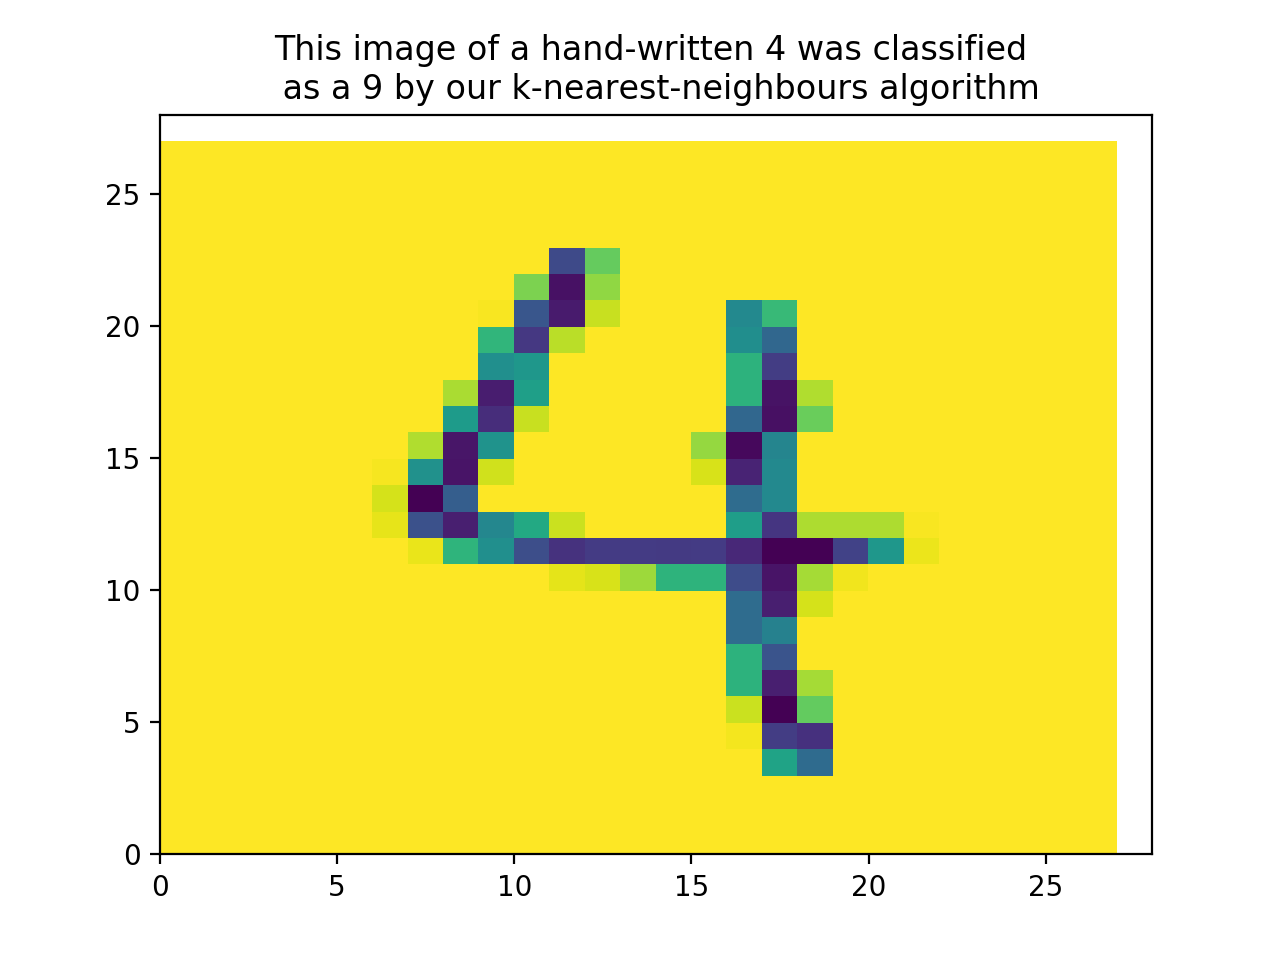

<IPython.core.display.Javascript object>


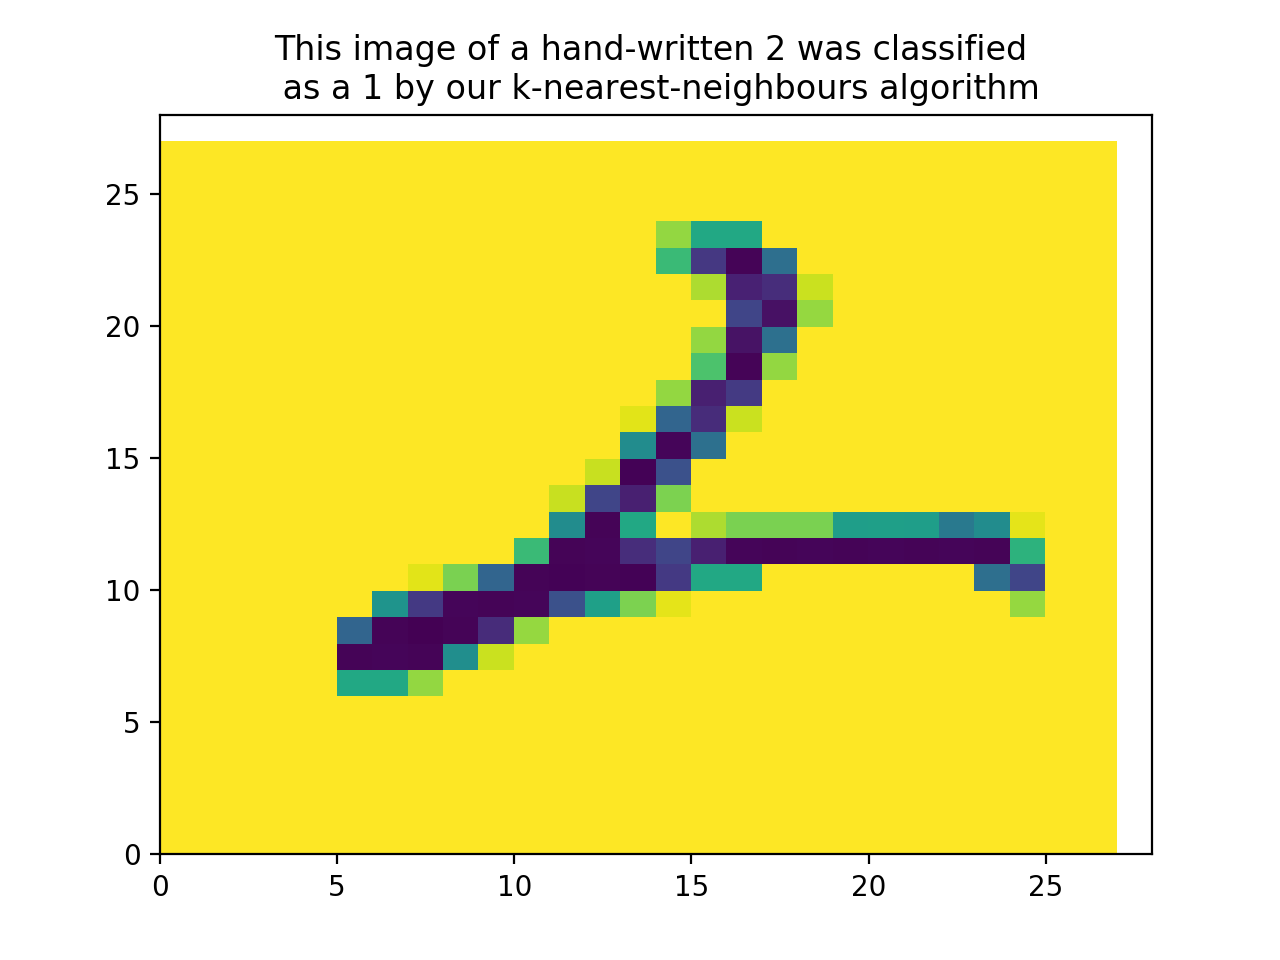

<IPython.core.display.Javascript object>


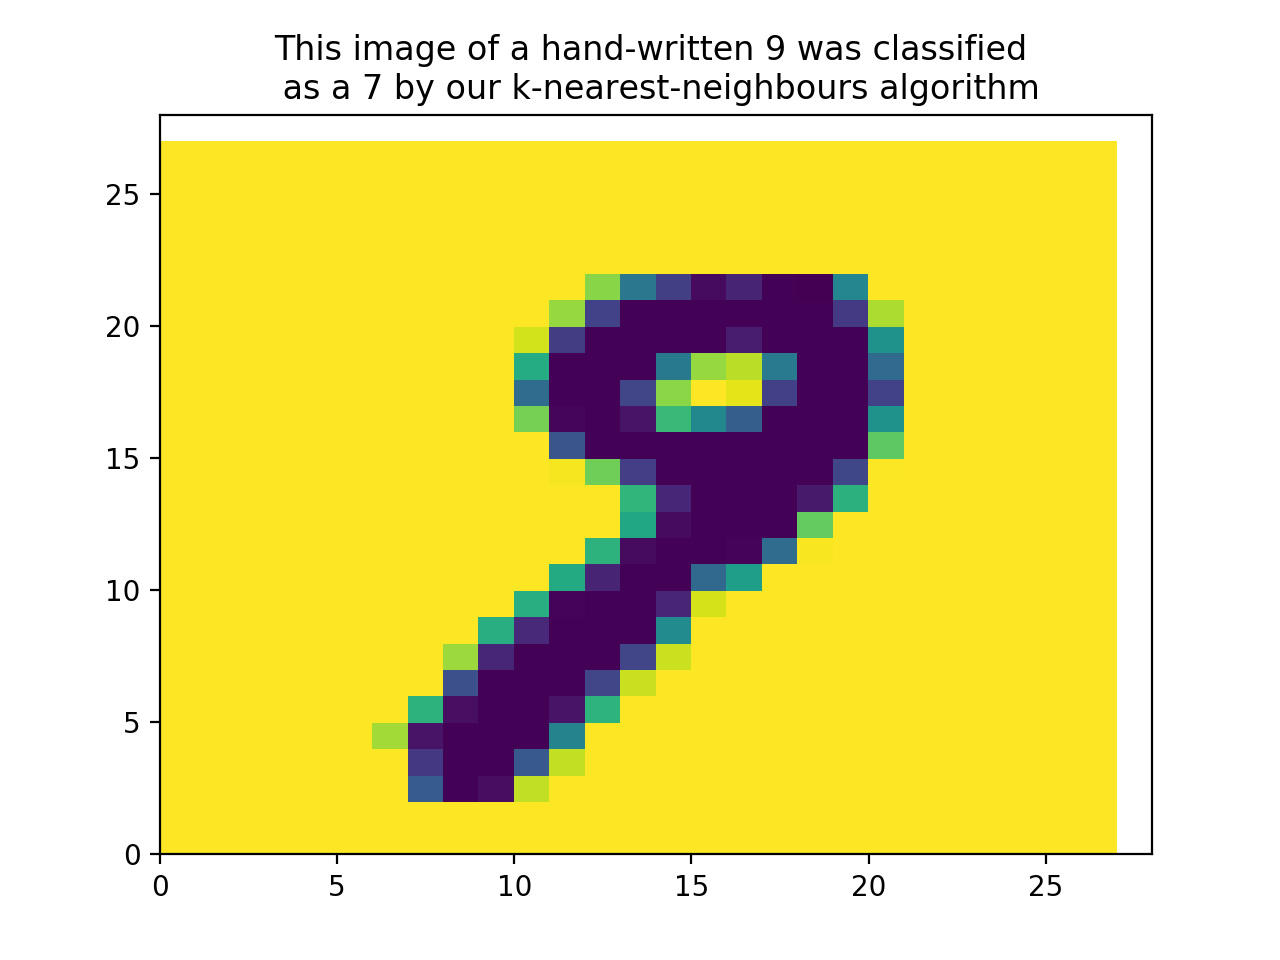

<IPython.core.display.Javascript object>


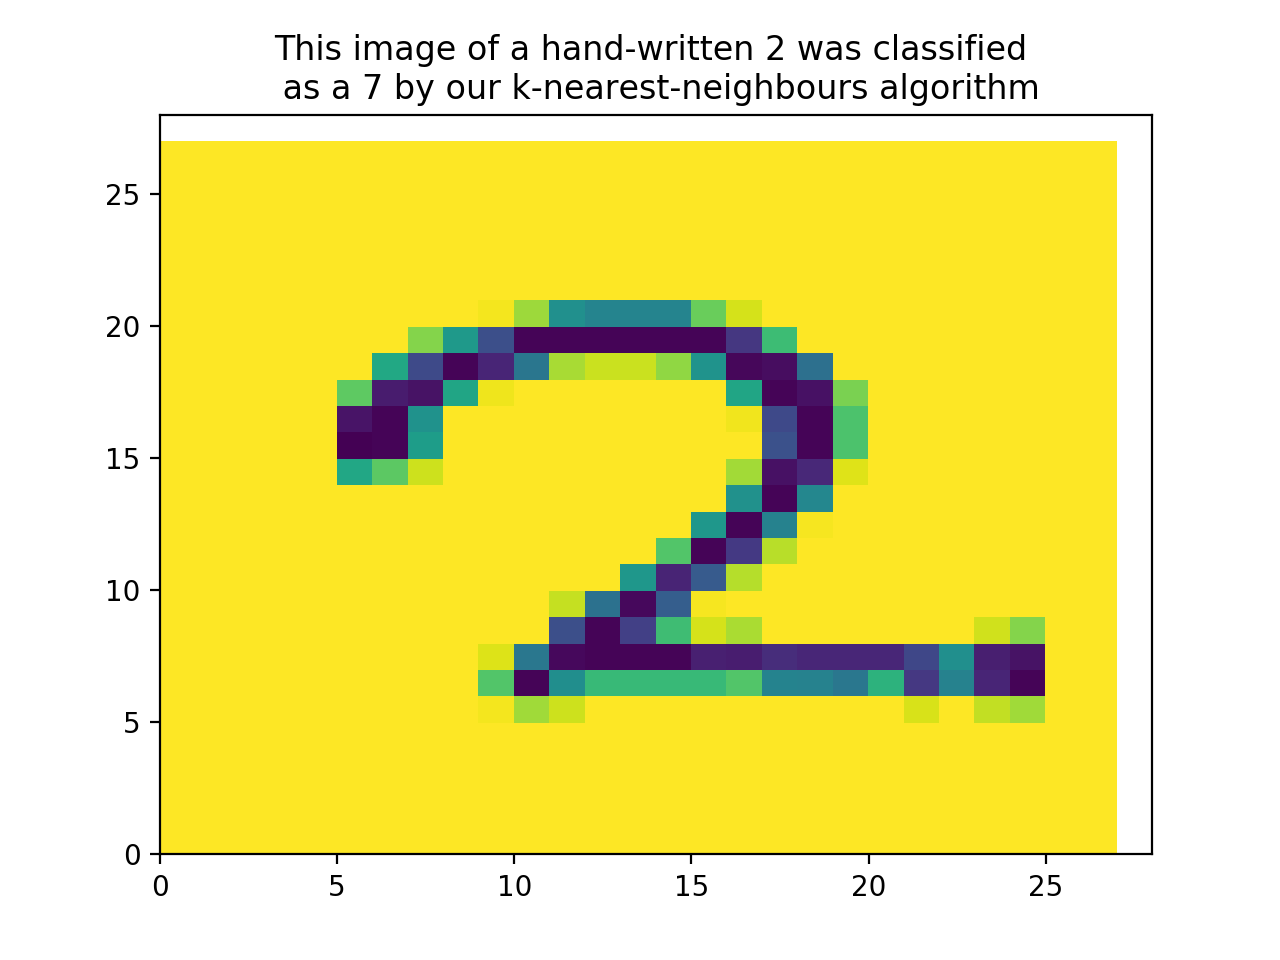

<IPython.core.display.Javascript object>


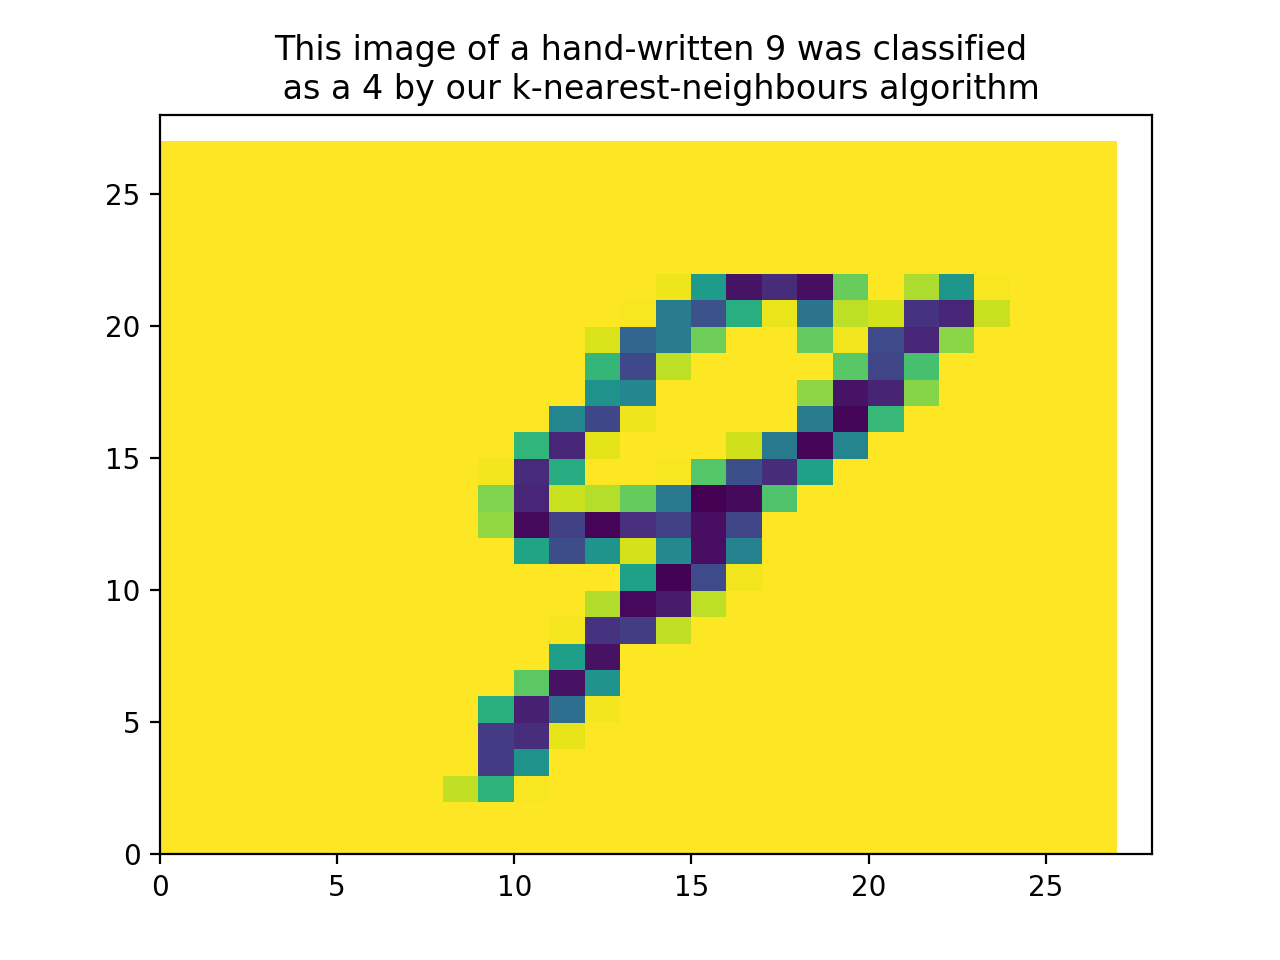

In [153]:
# initiate learn dataset from test dataset using list comprehension so that test_data will not be affected
learn_data = [y[:] for y in test_data[:]]
# initiate a list which will contain all examples where the classifier was wrong
mistake_data= []
        
# for each image in test_data apply the k nearest algorithm to find the closest match 
# among images from the train_data
for learn_item in learn_data:
    nearest_label = nearest_label_finder(learn_item[0],train_data)        
            
    # if the classifier was correct, then do nothing as learn_data has already inherited the correct labels
    # given in test_data
    if nearest_label == learn_item[1]:
        pass
    # if the classifier was incorrect, add the example to mistake_data and update the label in learn_data
    elif nearest_label != learn_item[1]:
        mistake_data.append(learn_item + [nearest_label])
        learn_item[1] = nearest_label
        
        # calculate the percentage accuracy of the algorithm
        total_correct = len(learn_data) - len(mistake_data)
        learn_accuracy = 100 * (total_correct) / len(learn_data)
        
print("The percentage accuracy of our k-nearest-neighbours algorithm is " + str(learn_accuracy) + ".\n")
print("Now let us show some examples where the classification algorithm was incorrect.")

X = np.arange(0,28)
Y = np.arange(0,28)

c = 0
for i in range(len(mistake_data)):
    
    mistake_image = mistake_data[i][0]
    correct_label = mistake_data[i][1]
    mistake_label = mistake_data[i][2]
    
    fig, ax = plt.subplots()
    ax.pcolormesh(X, Y, mistake_image)
    title = 'This image of a hand-written {}'.format(correct_label)
    title += ' was classified \n as a {} by our k-nearest-neighbours algorithm'.format(mistake_label)
    plt.title(title)    
    ax.set_xlim(0,28)
    ax.set_ylim(0,28)
    if c>3:
        break
    c += 1

### Learning accuracy
In order to test the effectiveness of our algorithm we plot percentage accuracy and runtime for various values of $k$ and $p$.

<IPython.core.display.Javascript object>


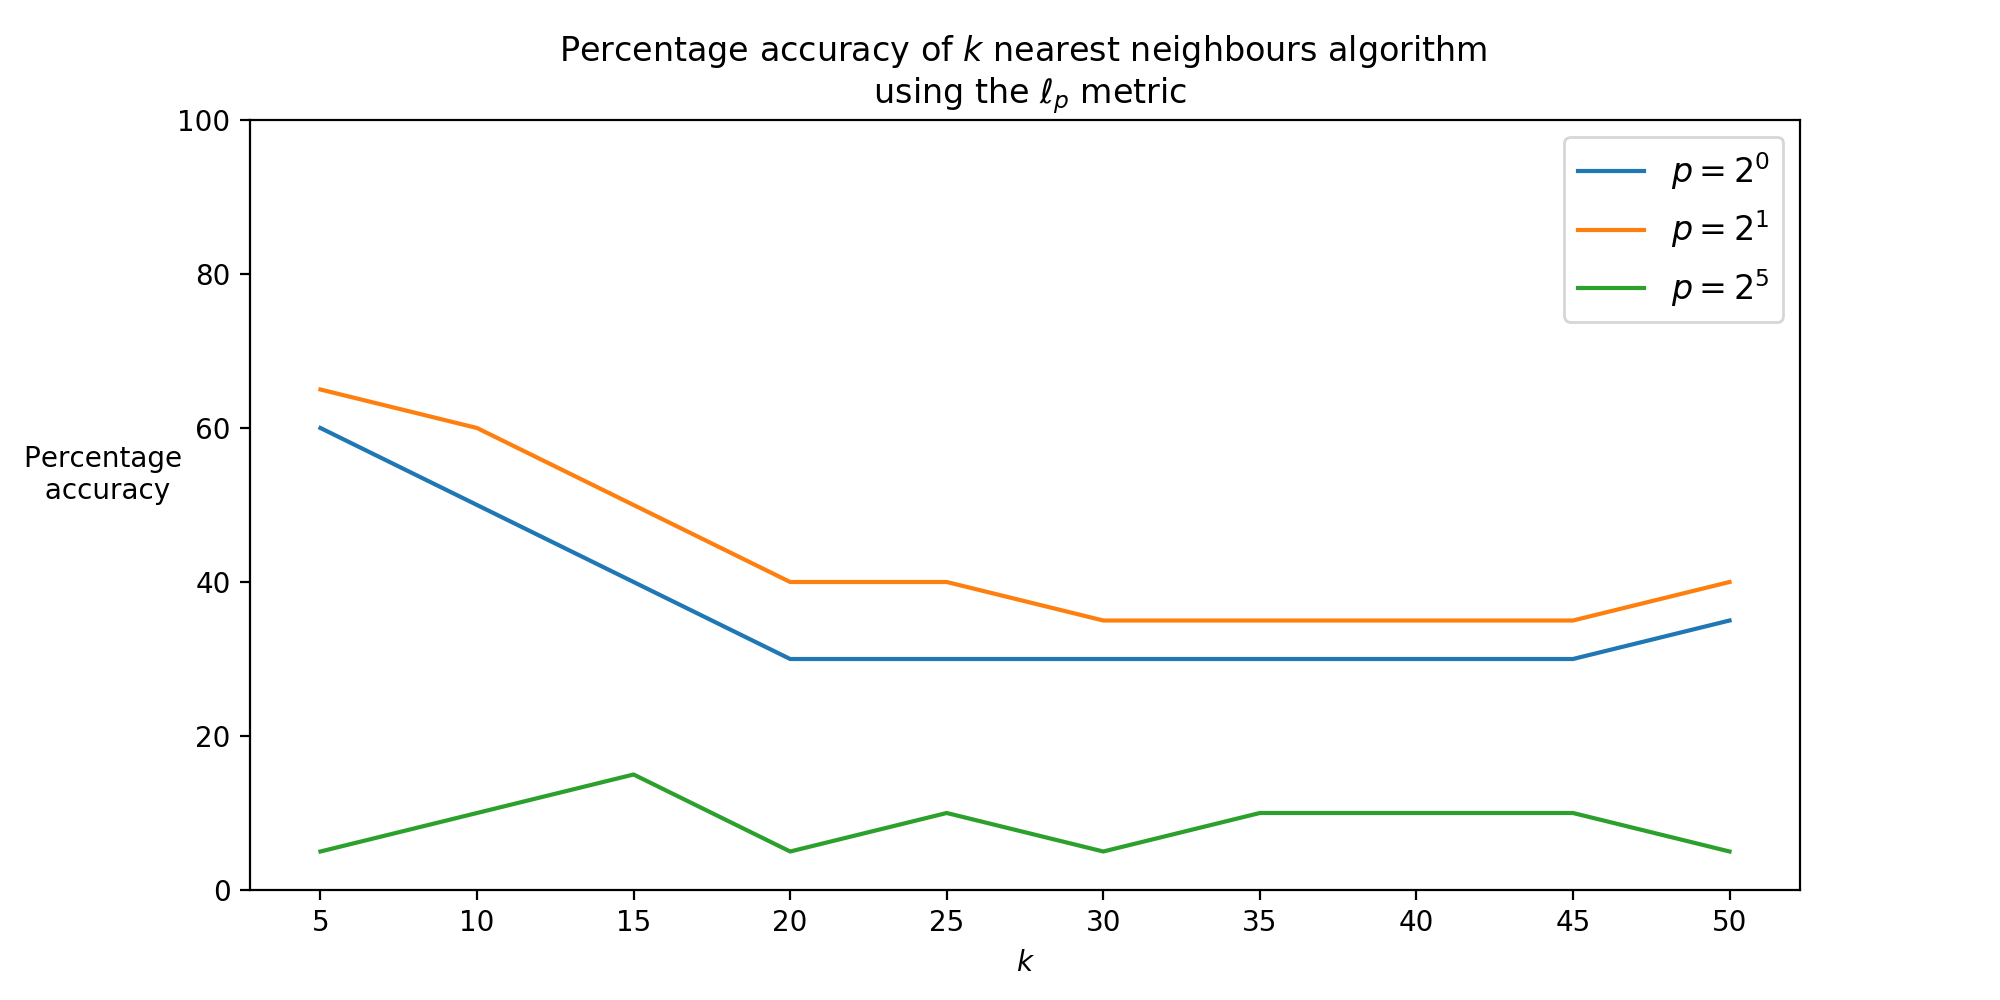

<IPython.core.display.Javascript object>


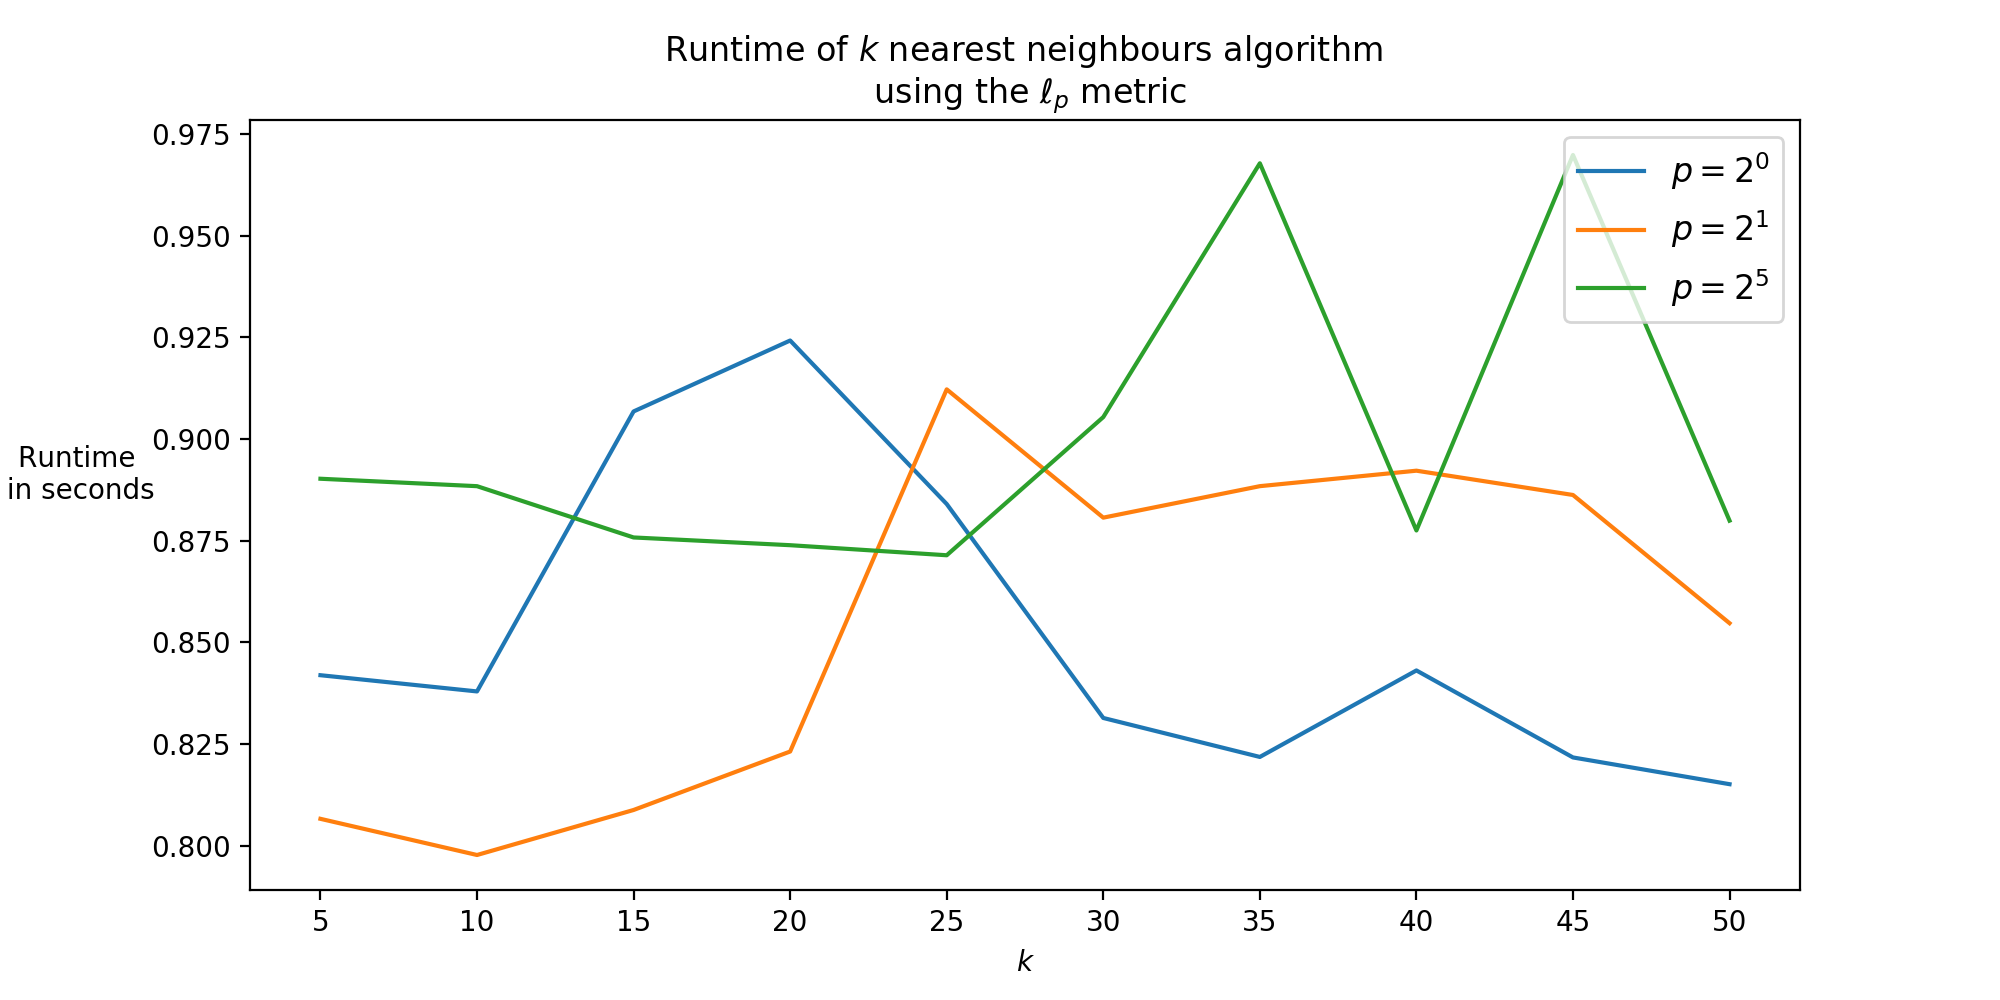

/Users/finlaymcintyre/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in long_scalars


In [134]:
# create parameter sets we are going to apply the algorithm with
k_values = [k for k in range(5,51,5)] 
p_exponents = [j for j in [0,1,5]]

t00 = time.time()
# Create figure and axes
fig_accuracy, ax_accuracy = plt.subplots(1, 1, figsize=(10, 5))
xi = list(range(len(k_values)))
plt.xticks(k_values, k_values)
plt.title('Percentage accuracy of $k$ nearest neighbours algorithm \n using the $\ell_p$ metric')
fig_runtime, ax_runtime = plt.subplots(1, 1, figsize=(10, 5))
plt.xticks(k_values, k_values)
plt.title('Runtime of $k$ nearest neighbours algorithm \n using the $\ell_p$ metric')
plt.show()

mistake_data = {}

# apply algorithm for various p and k values
for j in p_exponents:
    p = 2**j
    
    runtimes = []
    accuracies = []
    
    for k in k_values:
        
        learn_data = [y[:] for y in test_data[:]]
        mistake_data_current = []
        t0 = time.time()
        
        # for each image in the test_data apply the k nearest algorithm to find the closest match 
        # among images from the train_data
        for learn_item in learn_data:
            nearest_label = nearest_label_finder(learn_item[0],train_data,k,p)        
            
            #add the test_image with the learnt label as a two element list to learnt_data
            if nearest_label != learn_item[1]:
                mistake_data_current.append(learn_item + [nearest_label])
                learn_item[1] = nearest_label.copy()
                
        
        mistake_data[(k,p)] = mistake_data_current
        
        # calculate the runtime for each value of k
        t1 = time.time()
        runtimes.append((t1-t0))
        
        # find out the accuracy of the learning algorithm for each value of k
        total_correct = len(learn_data) - len(mistake_data_current)
        learn_accuracy = 100 * (total_correct) / len(learn_data)
        accuracies.append(learn_accuracy)
    
    
    
    ax_accuracy.plot(k_values, accuracies, '-', label = r'$p=2^{}$'.format(j))
    ax_accuracy.set_xlabel('$k$',fontsize=10)
    ax_accuracy.set_ylabel('Percentage \n accuracy ',rotation=0, fontsize=10, labelpad=25)   
    ax_accuracy.set_ylim(0,100)
    ax_accuracy.legend(loc='upper right', fontsize=12)
    
    
    ax_runtime.plot(k_values, runtimes, '-', label = r'$p=2^{}$'.format(j))
    ax_runtime.set_xlabel('$k$',fontsize=10)
    ax_runtime.set_ylabel('Runtime \n in seconds ',rotation=0, fontsize=10, labelpad=25)
    ax_runtime.legend(loc='upper right', fontsize=12)
    
t11 = time.time()
total_runtime = t11-t00
#print(total_runtime)

### References

\[1\] https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1

\[2\] https://www.python-course.eu/k_nearest_neighbor_classifier.php